In [17]:
import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [18]:
# Get data
n_seasons, n_TS, n_aliens, n_actions = 3, 3, 4, 3
n_trials, n_subj = 440, 31
alien_initial_Q = 0.12
# stimulus part 1
seasons = pd.read_csv("./1735_data/seasons.csv").values
# stimulus part 2
aliens = pd.read_csv("./1735_data/aliens.csv").values
# participants' selected actions
actions = pd.read_csv("./1735_data/actions.csv").values
# participants' received rewards
rewards = pd.read_csv("./1735_data/rewards.csv").values

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = trials.T
subj = subj.T

In [19]:
rewards

array([[ 0.3,  5.3,  1.5, ...,  7.8,  1.8,  1.7],
       [ 2.4,  0.9,  0.8, ...,  2.4,  2.4,  2.9],
       [ 2.3,  1.2,  1.2, ...,  0.7,  0.8,  3.6],
       ...,
       [ 1.6,  7.8,  4.3, ...,  5.1,  3.3,  0.4],
       [ 1.2,  0.6,  0.8, ..., 10.3,  0.9,  4. ],
       [ 1.2,  8.1,  1.6, ...,  5. ,  2.2,  1.3]])

In [20]:
rewards.shape

(440, 31)

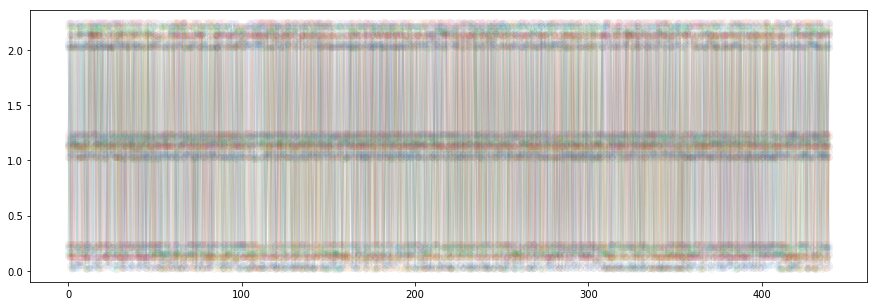

In [21]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(np.arange(actions.shape[0]), actions +
        np.random.rand(actions.shape[1])*.25, '-o', alpha=.05);

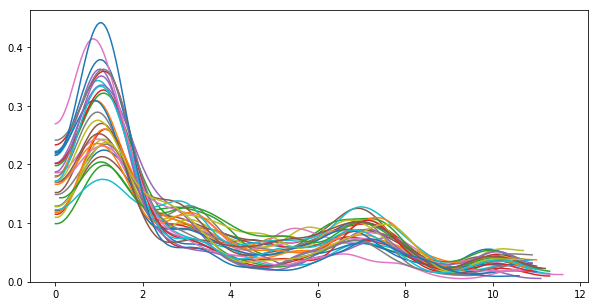

In [22]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
for isbj in range(rewards.shape[1]):
    pm.kdeplot(rewards[:, isbj], ax=ax);

In [23]:
rewards.min(), rewards.max()

(0.0, 11.6)

In [24]:
rewards.max(axis=0)

array([10.9, 11. , 11.1, 11. , 10.7, 10.7, 11.6, 10.9, 10.7, 11.3, 11. ,
       11. , 10.8, 11.3, 11.1, 11.1, 10.9, 10.8, 10.7, 10.9, 10.9, 10.9,
       11.3, 10.9, 10.9, 11.2, 10.6, 10.4, 10.7, 11.1, 10.6])

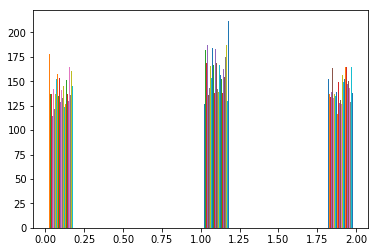

In [25]:
plt.hist(actions);

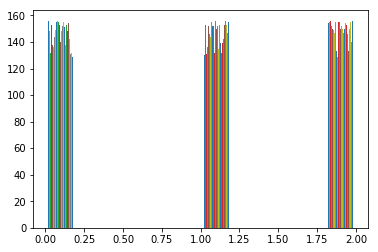

In [26]:
plt.hist(seasons);

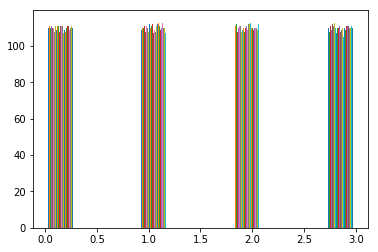

In [27]:
plt.hist(aliens);

In [28]:
zrewards = (rewards - rewards.mean(axis=0, keepdims=True)) / rewards.std(axis=0, keepdims=True)

In [29]:
iactions = actions[:, 0]
iseasons = seasons[:, 0]
ialiens = aliens[:, 0]
irewards = zrewards[:, 0]

In [30]:
alpha = tt.scalar('alpha')
alpha.tag.test_value = .1
forgets = tt.scalar('forgets')
forgets.tag.test_value = .5
Qlow = tt.tensor3('Q')
Qlow.tag.test_value = np.random.randn(n_TS, n_aliens, n_actions)


def onestep(season, alien, action, reward, Qlow, _, alpha, forget):
    Qnew = (1 - forget) * Qlow + forget * alien_initial_Q
    RPE_low = reward - Qnew[season, alien, action]
    Qnew = tt.set_subtensor(Qnew[season, alien, action],
                            Qnew[season, alien, action] + alpha * RPE_low)
    return [Qnew, Qnew[season, alien, :]]


([x_vals, y_vals], updates) = theano.scan(fn=onestep,
                                          sequences=[theano.shared(iseasons),
                                                     theano.shared(ialiens),
                                                     theano.shared(iactions),
                                                     theano.shared(irewards)],
                                          outputs_info=[
                                              Qlow, tt.ones(n_actions)],
                                          non_sequences=[alpha, forgets],
                                          strict=True)

# (x_vals[tt.arange(n_trials), iseasons, ialiens, :] - y_vals).tag.test_value

In [31]:
RL_func = theano.function(inputs=[Qlow, alpha, forgets], outputs=y_vals, updates=updates)

In [32]:
RL_func(np.ones((n_TS, n_aliens, n_actions)), .1, .1)

array([[ 0.912     ,  0.912     ,  0.69772843],
       [ 0.69614574,  0.8328    ,  0.8328    ],
       [ 0.76152   ,  0.62867482,  0.76152   ],
       ...,
       [ 0.08341229,  0.15156047, -0.0766376 ],
       [ 0.10478896, -0.08799466,  0.148677  ],
       [-0.00931549,  0.06259191,  0.02888349]])

In [36]:
T = theano.tensor

with pm.Model() as model:

    ## RL parameters: softmax temperature beta; learning rate alpha; forgetting of Q-values
    # Parameter shapes
    beta_shape = (1, n_subj, 1)  # Q_sub.shape -> [n_trials, n_subj, n_actions]
    forget_shape = (n_subj, 1, 1, 1)  # Q_low[0].shape -> [n_subj, n_TS, n_aliens, n_actions]
    beta_high_shape = (n_subj, 1)  # -> [n_subj, n_TS]
    forget_high_shape = (n_subj, 1, 1)  # -> [n_subj, n_seasons, n_TS]

    # Parameter means
    beta_mu = pm.Gamma('beta_mu', mu=1, sd=2, testval=1.5)
    alpha_mu = pm.Bound(pm.HalfNormal, upper=1)('alpha_mu', sd=0.5, testval=0.2)
    forget_mu = pm.Bound(pm.HalfNormal, upper=1)('forget_mu', sd=0.5, testval=0.1)
    beta_high_mu = pm.Gamma('beta_high_mu', mu=1, sd=2, testval=1.5)
    alpha_high_mu = pm.Bound(pm.HalfNormal, upper=1)('alpha_high_mu', sd=0.5, testval=0.2)
    forget_high_mu = pm.Bound(pm.HalfNormal, upper=1)('forget_high_mu', sd=0.5, testval=0.1)

    # Parameter sds
    beta_sd = pm.HalfNormal('beta_sd', sd=1, testval=0.1)
    alpha_sd = pm.HalfNormal('alpha_sd', sd=0.2, testval=0.1)
    forget_sd = pm.HalfNormal('forget_sd', sd=0.2, testval=0.1)
    beta_high_sd = pm.HalfNormal('beta_high_sd', sd=1, testval=0.1)
    alpha_high_sd = pm.HalfNormal('alpha_high_sd', sd=0.2, testval=0.1)
    forget_high_sd = pm.HalfNormal('forget_high_sd', sd=0.2, testval=0.1)

    # Individual differences
    beta_matt = pm.Bound(pm.Normal, lower=-beta_mu / beta_sd)(
        'beta_matt', mu=0, sd=1,
        shape=beta_shape, testval=np.random.choice([-1, 0, 1], n_subj).reshape(beta_shape))
    alpha_matt = pm.Bound(pm.Normal, lower=-alpha_mu / alpha_sd, upper=(1 - alpha_mu) / alpha_sd)(
        'alpha_matt', mu=0, sd=1,
        shape=n_subj, testval=np.random.choice([-1, 0, 1], n_subj))
    forget_matt = pm.Bound(pm.Normal, lower=-forget_mu / forget_sd, upper=(1 - forget_mu) / forget_sd)(
        'forget_matt', mu=0, sd=1,
        shape=forget_shape, testval=np.random.choice([0, 1], n_subj).reshape(forget_shape))
    beta_high_matt = pm.Bound(pm.Normal, lower=-beta_high_mu / beta_high_sd)(
        'beta_high_matt', mu=0, sd=1,
        shape=beta_high_shape, testval=np.random.choice([-1, 0, 1], n_subj).reshape(beta_high_shape))
    alpha_high_matt = pm.Bound(pm.Normal, lower=-alpha_high_mu / alpha_high_sd, upper=(1 - alpha_high_mu) / alpha_high_sd)(
        'alpha_high_matt', mu=0, sd=1,
        shape=n_subj, testval=np.random.choice([-1, 0, 1], n_subj))
    forget_high_matt = pm.Bound(pm.Normal, lower=-forget_high_mu / forget_high_sd, upper=(1 - forget_high_mu) / forget_high_sd)(
        'forget_high_matt', mu=0, sd=1,
        shape=forget_high_shape, testval=np.random.choice([0, 1], n_subj).reshape(forget_high_shape))

    # Put parameters together
    beta = pm.Deterministic('beta', beta_mu + beta_sd * beta_matt)
    alpha = pm.Deterministic('alpha', alpha_mu + alpha_sd * alpha_matt)
    forget = pm.Deterministic('forget', forget_mu + forget_sd * forget_matt)
    beta_high = pm.Deterministic('beta_high', beta_high_mu + beta_high_sd * beta_high_matt)
    alpha_high = pm.Deterministic('alpha_high', alpha_high_mu + alpha_high_sd * alpha_high_matt)
    forget_high = pm.Deterministic('forget_high', forget_high_mu + forget_high_sd * forget_high_matt)

    # Print resulting parameters
    T.printing.Print('beta')(beta)
    T.printing.Print('alpha')(alpha)
    T.printing.Print('forget')(forget)
    T.printing.Print('beta_high')(beta_high)
    T.printing.Print('alpha_high')(alpha_high)
    T.printing.Print('forget_high')(forget_high)

    ## Select action based on Q-values
    # Initialize Q-values
    Q_low0 = alien_initial_Q * T.ones([n_subj, n_TS, n_aliens, n_actions])
    Q_high0 = alien_initial_Q * T.ones([n_subj, n_seasons, n_TS])

    # Function to update Q-values based on stimulus, action, and reward
    def update_Qs(season, alien, action, reward,
                  Q_low, Q_high,
                  beta_high, alpha, alpha_high, forget, forget_high, n_subj):

        # Select TS
        Q_high_sub = Q_high[T.arange(n_subj), season]
        p_high = T.nnet.softmax(beta_high * Q_high_sub)
        T.printing.Print('Q_high_sub')(Q_high_sub)
        T.printing.Print('p_high')(p_high)
        
        
        ####################################################
        # MODEL IS WORKING WITH `TS = season`              #
        # MODEL CRASHES WITH `TS = p_high.argmax(axis=1)`  #
        ####################################################
        TS = season  # Flat
        # TS = p_high.argmax(axis=1)  # Hierarchical deterministic

        # Participant selects action based on TS and observes a reward

        # Forget Q-values a little bit
        Q_low = (1 - forget) * Q_low + forget * alien_initial_Q
        Q_high = (1 - forget_high) * Q_high + forget_high * alien_initial_Q  # TODO THIS IS WHERE THE NANS ARE INTRODUCED

        # Calculate RPEs & update Q-values
        current_trial_high = T.arange(n_subj), season, TS
        T.printing.Print('season')(season)
        T.printing.Print('TS')(TS)
        T.printing.Print('reward')(reward)
        RPE_high = reward - Q_high[current_trial_high]
        Q_high = T.set_subtensor(Q_high[current_trial_high],
                                 Q_high[current_trial_high] + alpha_high * RPE_high)

        current_trial_low = T.arange(n_subj), TS, alien, action
        RPE_low = reward - Q_low[current_trial_low]
        Q_low = T.set_subtensor(Q_low[current_trial_low],
                                Q_low[current_trial_low] + alpha * RPE_low)

        return [Q_low, Q_high, TS]

    # Calculate Q-values (update in each trial)
    [Q_low, Q_high, TS], _ = theano.scan(fn=update_Qs,
                                         sequences=[seasons, aliens, actions, rewards],
                                         outputs_info=[Q_low0, Q_high0, None],
                                         non_sequences=[beta_high, alpha, alpha_high, forget, forget_high, n_subj])

    Q_low = T.concatenate([[Q_low0], Q_low[:-1]], axis=0)  # Add first trial's Q-values, remove last trials Q-values
    Q_high = T.concatenate([[Q_high0], Q_high[:-1]], axis=0)  # Won't be used - just for printing
    T.printing.Print("Q_low")(Q_low)
    T.printing.Print("Q_high")(Q_high)

    # Select Q-values for each trial & translate into probabilities
    Q_sub = beta * Q_low[trials, subj, TS, aliens]  # Q_sub.shape -> [n_trials, n_subj, n_actions]
    action_wise_Q = Q_sub.reshape([n_trials * n_subj, n_actions])
    action_wise_p = T.nnet.softmax(action_wise_Q)

    # Select actions based on Q-values
    action_wise_actions = actions.flatten()
    actions = pm.Categorical('actions', p=action_wise_p, observed=action_wise_actions)
    T.printing.Print('action_wise_Q')(action_wise_Q)
    T.printing.Print('action_wise_p')(action_wise_p)

    # Check logps and draw samples
    print_logp_info(model)
    trace = pm.sample(100, tune=100, chains=2, cores=1, nuts_kwargs=dict(target_accept=.80))

beta __str__ = [[[1.4]
  [1.5]
  [1.4]
  [1.4]
  [1.5]
  [1.5]
  [1.4]
  [1.5]
  [1.4]
  [1.5]
  [1.5]
  [1.5]
  [1.4]
  [1.5]
  [1.5]
  [1.5]
  [1.5]
  [1.4]
  [1.5]
  [1.4]
  [1.5]
  [1.5]
  [1.6]
  [1.5]
  [1.6]
  [1.4]
  [1.5]
  [1.6]
  [1.5]
  [1.4]
  [1.5]]]
alpha __str__ = [0.2 0.1 0.3 0.3 0.2 0.2 0.2 0.1 0.3 0.3 0.2 0.2 0.1 0.2 0.1 0.3 0.2 0.1
 0.2 0.1 0.3 0.2 0.1 0.1 0.1 0.2 0.3 0.2 0.2 0.2 0.3]
forget __str__ = [[[[0.1]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.1]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.1]]]


 [[[0.2]]]


 [[[0.2]]]


 [[[0.2]]]]
beta_high __str__ = [[1.5]
 [1.5]
 [1.6]
 [1.6]
 [1.4]
 [1.6]
 [1.4]
 [1.6]
 [1.6]
 [1.4]
 [1.5]
 [1.4]
 [1.4]
 [1.6]
 [1.6]
 [1.5]
 [1.6]
 [1.5]
 [1.5]
 [1.5]
 [1.4]
 [1.6]

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
pm.traceplot(trace);